# 1. 데이터셋

## 1-1. AER 패키지의 College Distance 데이터셋

1980년대 미국 고등학생들 대상
성별, 인종, 부모의 교육 수준, 교육 연수 등과, 이 학생들이 미래의 소득 수준을 담고 있다.

이 변수들을 독립 변수로 해서 소득에 영향을 미치는지 단순히 다중 회귀 분석을 하면 되지 않을까?
현실적으로 데이터셋의 모든 변수를 포함해서 모형을 만들어도 관찰이나 측정이 어려워 데이터셋에 포함되지 못한 '개인의 능력'이나 '성실성', '인적 네트워크' 같은 특성들이 누락 변수(Omitted Variable)로서 내생성(Endogeneity)을 만들어낼 것이고, 그로 인해 독립 변수가 종속 변수에 미치는 영향이 과대 평가될 수 있다는 문제가 있다.

그렇다면 도구변수는 이러한 내생성 문제를 어떻게 해결해줄 수 있을까?

도구변수의 핵심 아이디어는 내생성을 가지기 쉬운 독립 변수의 변동을 두 가지로 나누어 생각하는 것이다. 일부는 오차항 속에서 내생성을 유발하는 누락 변수와 관련된 변동, 다른 부분은 오차항과는 무관하게 외생적인(exogeneous) 요인에 의해 발생한 변동이다. 이 둘을 분리할 수 있다면, 이 중 '좋은 변동'이라고 할 수 있는 외생적 변동이 종속 변수에 미치는 영향을 측정해서 인과 효과를 추론할 수 있게 된다.

예를 들어 마치 무작위로 배정된 것처럼 보이는 외생적 요인(도구변수)이 사람들의 교육 수준(이 데이터에서 우리가 인과효과를 궁금해 하는 설명 변수)을 변화시키고, 이 변화가 소득(이 데이터셋에서 우리가 궁금해하는 결과 변수)에 미치는 영향을 추정하는 것이다.

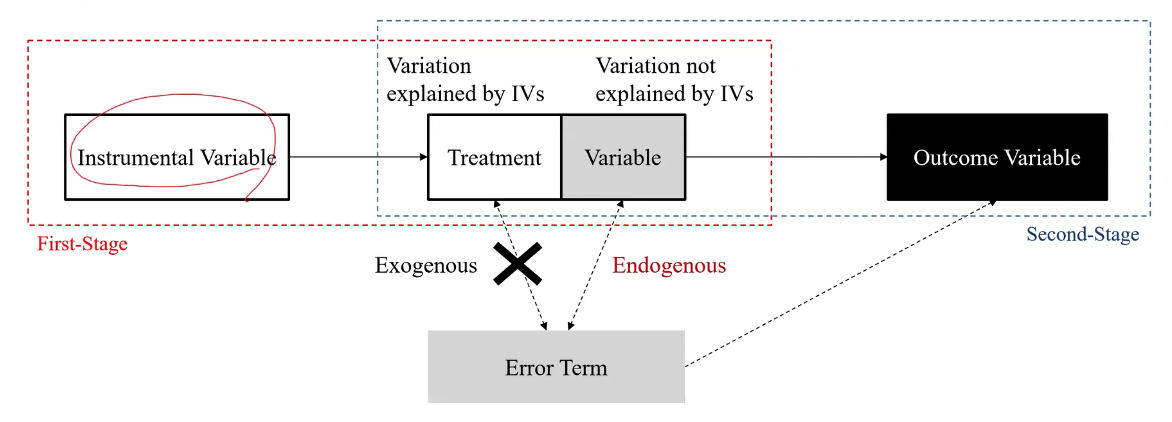


### 변수 설명

- 출처: https://search.r-project.org/CRAN/refmans/AER/html/CollegeDistance.html

변수명만 보고 파악하기 어려운 변수 위주로 기술
- `score`: 고등학생들의 기준 연도 종합 시험 점수
- `fcollege`, `mcollege`: 아버지 혹은 어머니가 대학을 졸업했는지
- `home`: 가족이 그들의 집을 소유하고 있는지(자가 여부)
- `urban`: 학교가 도시에 있는지 여부
- `unemp`: 1980년대 미국의 실업률
- `wage`:  1980년대 주의 제조업 평균 임금
- `distance`: 4년제 대학교와의 거리 (10 마일 단위)
- `tuition`: 4년제 주립 대학의 평균 등록금(1000 USD 단위)
- `income`: 가족의 수입이 연에 US 25000이 넘는지 여부 -> 이게 종속변수라고 생각했는데 아니다.
- `region`: 사는 지역이 서부인지 아닌지

In [33]:
!pip install linearmodels

In [4]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

In [4]:
file_path = 'CollegeDistance.csv'
data = pd.read_csv(file_path)
data.head()

,rownames,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
0,1,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
1,2,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
2,3,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,4,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,5,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4739 entries, 0 to 4738
Data columns (total 15 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   rownames   4739 non-null   int64  
 1   gender     4739 non-null   object 
 2   ethnicity  4739 non-null   object 
 3   score      4739 non-null   float64
 4   fcollege   4739 non-null   object 
 5   mcollege   4739 non-null   object 
 6   home       4739 non-null   object 
 7   urban      4739 non-null   object 
 8   unemp      4739 non-null   float64
 9   wage       4739 non-null   float64
 10  distance   4739 non-null   float64
 11  tuition    4739 non-null   float64
 12  education  4739 non-null   int64  
 13  income     4739 non-null   object 
 14  region     4739 non-null   object 
dtypes: float64(5), int64(2), object(8)
memory usage: 555.5+ KB


In [6]:
# 범주형 변수에 대해 범주 확인
categorical_columns = ['ethnicity', 'fcollege', 'mcollege', 'home', 'income', 'region']
for col in categorical_columns:
    print(f"{col}: {data[col].unique()}")

ethnicity: ['other' 'afam' 'hispanic']
fcollege: ['yes' 'no']
mcollege: ['no' 'yes']
home: ['yes' 'no']
income: ['high' 'low']
region: ['other' 'west']


In [7]:
data.describe()

,rownames,score,unemp,wage,distance,tuition,education
count,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000
mean,3954.638953,50.889029,7.597215,9.500506,1.802870,0.814608,13.807765
std,5953.827761,8.701910,2.763581,1.343067,2.297128,0.339504,1.789107
min,1.000000,28.950001,1.400000,6.590000,0.000000,0.257510,12.000000
25%,1185.500000,43.924999,5.900000,8.850000,0.400000,0.484990,12.000000
50%,2370.000000,51.189999,7.100000,9.680000,1.000000,0.824480,13.000000
75%,3554.500000,57.769999,8.900000,10.150000,2.500000,1.127020,16.000000
max,37810.000000,72.809998,24.900000,12.960000,20.000000,1.404160,18.000000


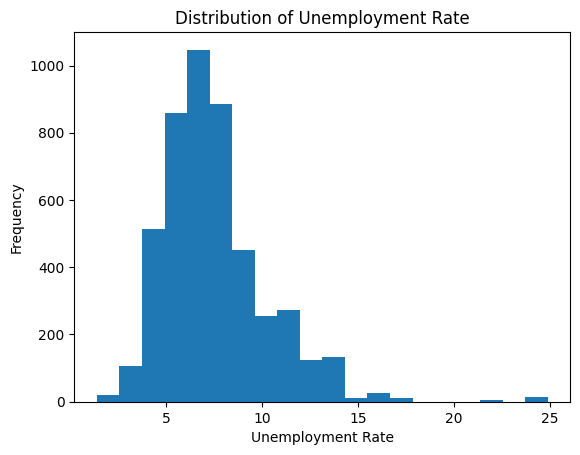

In [8]:
# unemp의 분포 시각화 해서 확인
import matplotlib.pyplot as plt

plt.hist(data['unemp'], bins=20)
plt.xlabel('Unemployment Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Unemployment Rate')
plt.show()

In [9]:
# region이 서부인지 아닌지에 따라 unemp, wage, tution에 차이가 많이 나는지 확인

data.groupby('region')[['unemp', 'wage', 'tuition']].agg('mean')

,unemp,wage,tuition
region,,,
other,7.654874,9.556499,0.913140
west,7.365111,9.275112,0.417975


다른 건 큰 차이가 안 나고, 다만 등록금은 오히려 west 지역이 훨씬 저렴하다.

앗 지금 보니 이 파일에는 결과변수인 학생의 미래 임금값이 없다...

이러면 도구변수 -> distance 로 가는 1단계는 구할 수 있지만 distance -> 결과변수(미래의 임금)의 영향을 추정하는 2단계를 구할 수 없다. 🤕

결과 변수까지 포함된 데이터셋을 새로 찾아보자.

## 1-2. Card (1995) 데이터

Card(1995)와 AER의 CollegeDistance 데이터셋 둘 다 도구변수 프레임으로 교육 기간이나 임금을 추정하는 데에 대학과의 거리를 도구변수로 사용하기는 했다.

### 두 데이터셋의 차이점
- Card(1995)는 NLSY(1996~1976년) 코호트를 사용해서 '젊은 남성'만을 대상으로 만든 데이터셋이라 '성별' 정보가 없고, IQ 점수, 결혼 여부, 도서관 카드 소지 여부, 거주지역 등에 대한 더 자세한 정보가 있음.
- Watson/AER의 CollegeDistance에는 결과 변수인 임금이 없는 반면, Card 데이터셋에는 log값을 취한 wage데이터가 존재


### 컬럼 설명

  - `id`: 개인 식별자
  - **`nearc2`**: 1966년에 2년제 대학 근처에 거주했는지 여부 -> 도구변수 후보2
  - **`nearc4`**: 1966년에 4년제 대학 근처에 거주했는지 여부 -> 도구변수 후보1
  - `educ`: 1976년 기준, 총 교육 연수
  - `age`: 1976년 기준, 나이
  - `fatheduc`: 아버지의 총 교육 연수
  - `motheduc`: 어머니의 총 교육 연수
  - **`weight`**: 표본 가중치
  - `momdad14`: 14세 때 부모님과 함께 살았는지 여부
  - `sinmom14`: 14세 때 편모 가정이었는지 여부
  - `step14`: 14세 때 의붓 부모가 있었는지 여부
  - `reg661` \~ `reg669`: 1966년 거주 지역을 나타내는 9개의 더미 변수
  - `south66`: 1966년에 미국 남부 지역에 거주했는지 여부
  - `black`: 인종 (1 = 흑인, 0 = 백인)
  - `smsa`: 1976년에 대도시(SMSA)에 거주했는지 여부
  - `south`: 1976년에 미국 남부 지역에 거주했는지 여부
  - `smsa66`: 1966년에 대도시(SMSA)에 거주했는지 여부
  - `wage`: 1976년 기준, 시간당 임금
  - `enroll`: 1976년에 학교에 등록했는지 여부
  - `KWW`: 직업 세계 지식 점수
  - `IQ`: IQ 점수
  - `married`: 1976년 기준, 결혼 여부
  - `libcrd14`: 14세 때 지역에 도서관 카드가 있었는지 여부
  - `exper`: 실제 총 노동 경험 연수 -> 어떤 시점의 노동 경험 연수이려나..
  - **`lwage`**: 임금의 자연로그 값 -> 이게 결과변수
  - `expersq`: 경험의 제곱 값
  - `u_lwage`: (잔차항, 특정 모델에서 생성된 변수로 추정)
  - `lwage_hat`: (예측값, 특정 모델에서 생성된 변수로 추정)
  - `u_educ`: (잔차항, 특정 모델에서 생성된 변수로 추정)



### 그럼 'weight'는 무슨 변수인가요?


  * **`weight`**: **표본 가중치 (Sampling Weight)**
      * **설명**: `card.dta`의 원본 데이터인 NLSY는 미국 전체 청년층을 대표하기 위해 설계되었습니다. 이 과정에서 특정 그룹(예: 소수인종)은 의도적으로 더 많이 표본에 포함되기도 합니다. `weight` 변수는 이렇게 일반적인 인구 구성과 달라진 부분을 보정하여, 분석 결과를 미국 전체 청년층에 대한 대표성을 갖는 값으로 만들어주기 위한 \*\*'가중치'\*\*입니다.
      * **활용**: 대부분의 회귀분석 라이브러리(예: `statsmodels`의 `WLS` - 가중 최소 제곱법)에서는 이 `weight` 변수를 적용하여 분석의 정확도를 높일 수 있는 옵션을 제공합니다.

In [36]:
file_path = 'card.dta'
df = pd.read_stata(file_path)

print(df.shape)
df.head()

(3010, 37)


,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,step14,reg661,reg662,reg663,reg664,reg665,reg666,reg667,reg668,reg669,south66,black,smsa,south,smsa66,wage,enroll,KWW,IQ,married,libcrd14,exper,lwage,expersq,u_lwage,lwage_hat,u_educ
0,2.0,0.0,0.0,7.0,29.0,NaN,NaN,158413.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,548.0,0.0,15.0,NaN,1.0,0.0,16.0,6.306275,256.0,0.198047,6.108228,-3.067539
1,3.0,0.0,0.0,12.0,27.0,8.0,8.0,380166.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,481.0,0.0,35.0,93.0,1.0,1.0,9.0,6.175867,81.0,-0.211160,6.387027,-1.727562
2,4.0,0.0,0.0,12.0,34.0,14.0,12.0,367470.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,721.0,0.0,42.0,103.0,1.0,1.0,16.0,6.580639,256.0,0.204719,6.375920,1.012975
3,5.0,1.0,1.0,11.0,27.0,11.0,12.0,380166.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,250.0,0.0,25.0,88.0,1.0,1.0,10.0,5.521461,100.0,-0.967905,6.489366,-2.253536
4,6.0,1.0,1.0,12.0,34.0,8.0,7.0,367470.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,729.0,0.0,34.0,108.0,1.0,0.0,16.0,6.591674,256.0,0.125173,6.466501,1.090437


In [37]:
df.describe()

,id,nearc2,nearc4,educ,age,fatheduc,motheduc,weight,momdad14,sinmom14,step14,reg661,reg662,reg663,reg664,reg665,reg666,reg667,reg668,reg669,south66,black,smsa,south,smsa66,wage,enroll,KWW,IQ,married,libcrd14,exper,lwage,expersq,u_lwage,lwage_hat,u_educ
count,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,2320.000000,2657.000000,3.010000e+03,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,3010.000000,2963.000000,2061.000000,3003.000000,2997.000000,3010.000000,3010.000000,3010.000000,3.010000e+03,3010.000000,3.010000e+03
mean,2581.748779,0.440864,0.682060,13.263455,28.119602,10.003448,10.348137,3.211852e+05,0.789369,0.100664,0.038870,0.046512,0.160797,0.195681,0.064120,0.208306,0.096013,0.109967,0.028239,0.090365,0.414286,0.233555,0.712957,0.403654,0.649502,577.282410,0.092359,33.540668,102.449783,2.271395,0.674341,8.856146,6.261832,95.579071,-1.584177e-09,6.261832,-5.069365e-09
std,1500.539062,0.496568,0.465752,2.676915,3.136993,3.720742,3.179669,1.706459e+05,0.407830,0.300932,0.193318,0.210633,0.367396,0.396797,0.244999,0.406165,0.294657,0.312904,0.165685,0.286752,0.492680,0.423159,0.452458,0.490714,0.477213,262.958221,0.289579,8.611625,15.423761,2.066792,0.468697,4.141675,0.443797,84.618492,3.986206e-01,0.195084,1.939976e+00
min,2.000000,0.000000,0.000000,1.000000,24.000000,0.000000,0.000000,7.560700e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000,4.000000,50.000000,1.000000,0.000000,0.000000,4.605170,0.000000,-1.565711e+00,5.625848,-7.524803e+00
25%,1275.500000,0.000000,0.000000,12.000000,25.000000,8.000000,8.000000,1.227980e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,394.250000,0.000000,28.000000,93.000000,1.000000,0.000000,6.000000,5.976985,36.000000,-2.503953e-01,6.131938,-1.368187e+00
50%,2541.000000,0.000000,1.000000,13.000000,28.000000,10.000000,12.000000,3.652000e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,537.500000,0.000000,34.000000,103.000000,1.000000,1.000000,8.000000,6.286928,64.000000,1.281819e-02,6.284742,-7.355188e-02
75%,3858.750000,1.000000,1.000000,16.000000,31.000000,12.000000,12.000000,4.060240e+05,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,708.750000,0.000000,40.000000,113.000000,4.000000,1.000000,11.000000,6.563503,121.000000,2.709934e-01,6.415647,1.266893e+00
max,5225.000000,1.000000,1.000000,18.000000,34.000000,18.000000,18.000000,1.752340e+06,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2404.000000,1.000000,56.000000,149.000000,6.000000,1.000000,23.000000,7.784889,529.000000,1.394286e+00,6.548606,6.003512e+00


In [38]:
# null값이 있는 컬럼만 확인
for col in df.columns:
  if df[col].isnull().sum() > 0:
    print(f'{col}: {df[col].isnull().sum()} null values')

fatheduc: 690 null values
motheduc: 353 null values
KWW: 47 null values
IQ: 949 null values
married: 7 null values
libcrd14: 13 null values


# 2. OLS와 2SLS 분석

내생성 문제를 가지고 있는 데이터에 대해 회귀분석을 한 결과와 내생성을 분리한 도구변수 방법론을 사용하여 각각 결과변수에 대한 '대학까지의 거리 변수'의 영향을 추정해서 얼만큼 차이가 나는지(=내생성으로 인해 교육의 효과가 얼만큼 과소 또는 과대평가 되었는지)를 확인할 수 있을 것이다.

결과가 76년까지의 종단 연구라면, 변수 중에 조사 시작시점(66년), 종료시점(76년)에 측정한 것들이 섞여있는 것에 유의할 필요가 있어보인다. 예를 들어 76년의 거주 대도시 거주 여부(smsa) 같은 것은 결과에 영향을 미친 요인이라고 보기 어려울 것이다.

In [42]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from linearmodels.iv import IV2SLS

In [43]:
# 공통
file_path = 'card.dta'
df = pd.read_stata(file_path)

controls = ['fatheduc', 'motheduc', 'exper','KWW','IQ', 'expersq', 'black', 'smsa66']
all_cols = ['lwage', 'educ', 'nearc4'] + controls

d1 = df[all_cols].dropna().copy()

In [45]:
d1.head()

,lwage,educ,nearc4,fatheduc,motheduc,exper,KWW,IQ,expersq,black,smsa66
1,6.175867,12.0,0.0,8.0,8.0,9.0,35.0,93.0,81.0,0.0,1.0
2,6.580639,12.0,0.0,14.0,12.0,16.0,42.0,103.0,256.0,0.0,1.0
3,5.521461,11.0,1.0,11.0,12.0,10.0,25.0,88.0,100.0,0.0,1.0
4,6.591674,12.0,1.0,8.0,7.0,16.0,34.0,108.0,256.0,0.0,1.0
5,6.214608,12.0,1.0,9.0,12.0,8.0,38.0,85.0,64.0,0.0,1.0


## 2-1. OLS로 다중회귀분석

In [47]:

y_ols = d1['lwage']
X_ols = sm.add_constant(d1[['educ'] + controls]) # 상수항 추가

# OLS model fitting
ols_model = sm.OLS(y_ols, X_ols)
ols_results = ols_model.fit(cov_type='HC1') # 강건한 오차 사용 - ?

# Print the summary
print("----------- OLS 분석 결과 ----------")
print(ols_results.summary())

----------- OLS 분석 결과 ----------
                            OLS Regression Results                            
Dep. Variable:                  lwage   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     44.91
Date:                Sun, 31 Aug 2025   Prob (F-statistic):           2.76e-72
Time:                        08:12:43   Log-Likelihood:                -702.55
No. Observations:                1604   AIC:                             1425.
Df Residuals:                    1594   BIC:                             1479.
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.45

통계적으로 유의하고 영향이 큰 결과를 보이는 변수들
- educ(연속형 변수): 교육 기간이 1년 늘어날 때 임금이 6.3% 정도 증가한다.
- smsa66(대도시 거주 여부), 인종(black), 노동 경험 연수(expersq)들도 통계적으로 유의하면서 결과변수에 큰 영향을 미친 것으로 나타난다.

## 2-2. 2SLS

이번에는 대학 근처 거주 여부를 그냥 변수에 넣지 않고 도구변수로 사용해서 교육 정도가 임금에 미치는 영향을 더 정확히 식별해보자.

In [50]:

y_iv = d1['lwage']
exog_vars = sm.add_constant(d1[controls]) # 외생 회귀 변수
endog_var = d1['educ'] # 내생 회귀변수
instr_var = d1[['nearc4']] # 도구 변수


# IV 2SLS model fitting
iv_model = IV2SLS(
    dependent=y_iv,
    exog=exog_vars,
    endog=endog_var,
    instruments=instr_var
)

iv_result = iv_model.fit()

print("----------- 2SLS 분석 결과 ----------")
print(iv_result)

----------- 2SLS 분석 결과 ----------
                          IV-2SLS Estimation Summary                          
Dep. Variable:                  lwage   R-squared:                      0.1772
Estimator:                    IV-2SLS   Adj. R-squared:                 0.1725
No. Observations:                1604   F-statistic:                    312.58
Date:                Sun, Aug 31 2025   P-value (F-stat)                0.0000
Time:                        08:16:45   Distribution:                  chi2(9)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          4.0235     0.8451     4.7609     0.0000      2.3671      5.6799
fatheduc      -0.0

# 3. 결과 비교

교육(education)이 미래의 임금에 미치는 영향이 앞서 회귀분석에서 얻은 0.064에 비해 큰 0.1058로 나타남. 즉 교육연한이 1년 늘어날 때마다 임금이 10.6% 상승하는 효과. 단 범위가 -5.7% ~ 26.9%로 넓고 p-value가 0.20으로 커서 통계적 유의성은 떨어지는 결과.


### 3-1. OLS vs 2SLS
1. OLS가 오히려 교육이 임금 수준에 미치는 영향을 과소 평가하고 있다.
- 초반에는 오히려 '개인의 능력', '성실성' 같은 지표가 미치는 영향이 OLS에서 '교육'의 영향을 과대평가하는 것이 아닐까 걱정했지만 그렇지 않았다.
- 이는 이미 IQ와 같은 개인의 능력을 어느 정도 반영하는 지표가 변수에 포함되어 있기 때문일 수 있다.
- 만약 데이터셋에서 교육 연한은 낮지만 직업적으로 성공을 거둔(대학 자퇴한 빌게이츠 처럼.. ) 학생들이 많이 포함이 되어있었다면, OLS는 이런 학생들의 영향까지 포함하여 평균적으로 교육의 효과를 실제보다 낮게 평가했을 수 있다.
- 반면 도구변수는 구조 상 순응자(complier)에만 집중하기 때문에, 위와 같은 Never-Taker의 영향을 무시함으로써 도구변수(대학과의 거리)에 영향을 받아 교육 수준이 달라진 순응자 그룹의 평균적인 인과 효과만을 정확히 추정하게 된 것



### 3-2. 처치에 반응하는 네 가지 유형에 따른 해석

- $\beta_{2SLS}$: 2단계 최소제곱법(2SLS)으로 추정한 계수(인과 효과)입니다.
- $Y$: 종속 변수 (우리의 예시에서는 $lwage$)
- $X$: 내생성을 가진 독립 변수 (우리의 예시에서는 $educ$)
- $Z$: 도구 변수 (우리의 예시에서는 $nearc4$)
- $\text{Cov}(Y, Z)$: 종속 변수와 도구 변수 간의 공분산입니다.
- $\text{Cov}(X, Z)$: 내생 변수와 도구 변수 간의 공분산입니다 (1단계 분석의 핵심)

라고 할 때, 2SLS 추정치를 다음과 같은 도구변수와 독립 변수, 독립변수와 종속 변수의 공분산의 비율로 나타낼 수 있다.

$$ \beta_{2SLS} \approx \frac{\text{Cov}(Y, Z)}{\text{Cov}(X, Z)}$$

여기서 각 그룹이 2SLS 추정치에 미치는 영향을 보면,

- Always-Takers: 대학이 가깝든 멀든 무조건 대학에 가는 그룹. 이들은 nearc4가 0이든 1이든 항상 대학에 가므로, nearc4의 변화가 이들의 educ를 변화시키지 못함.
- Never-Takers: 대학이 집 가까이에 있어도 절대 대학에 가지 않는 그룹. 이들은 nearc4가 0이든 1이든 항상 대학에 가지 않으므로, 역시 educ 변화에 아무런 기여를 하지 않음
- Compliers: 대학이 가까우면 대학에 가고, 멀면 가지 않는 그룹. 이들은 nearc4가 1이 되면 educ가 높아지고, 0이 되면 낮아집니다. -> 이 그룹만이 위 식에서 분모와 분자의 값에 영향을 미침
- Defier: 대학이 가까우면 오히려 가지 않고 멀면 감 -> 일반적으로는 없다고 가정


**결론: 위 그룹을 기준으로 다시 OLS로 추정된 교육의 영향이 도구변수로 추정된 교육의 영향보다 작았던 이유를 설명하면, 데이터셋에 never-taker나 always-taker들이 꽤 많았기 때문일 수 있다.**

# (추가) 두 번의 OLS를 통해 2SLS에서 도구변수가 어떻게 편향을 교정하는지 확인

이번에는 2SLS를 OLS를 두 번 사용해서 구현하는 방식으로 도구변수가 설명변수 educ에 어떻게 영향을 주는지 확인해보자.

In [62]:
# 1) 데이터 준비
df = pd.read_stata('card.dta')

controls = ['fatheduc','motheduc','KWW','IQ','expersq','black','smsa66']
all_cols = ['lwage','educ','nearc4'] + controls

# 공통 표본 만들기
d1 = df[all_cols].dropna().copy()
d1 = sm.add_constant(d1)  # const 열 추가(공통 표본에 맞춰서 추가)

exog_vars_list = ['const'] + controls

# --- 1단계: educ ~ nearc4 + controls ---
y1 = d1['educ']
X1 = d1[['nearc4'] + exog_vars_list]
stage1_results = sm.OLS(y1, X1).fit(cov_type='HC1')
d1['educ_hat'] = stage1_results.fittedvalues   # predict()와 동일, 인덱스 일치

# --- 2단계: lwage ~ educ_hat + controls ---
y2 = d1['lwage']
X2 = d1[['educ_hat'] + exog_vars_list]
stage2_results = sm.OLS(y2, X2).fit(cov_type='HC1')

# --- 결과 출력 ---
print("---" * 20)
print("           [1단계 결과] 도구변수가 교육에 미치는 영향")
print("---" * 20)
print(stage1_results.summary())

print("\n\n" + "---" * 20)
print("       [2단계 결과] 정화된 교육이 임금에 미치는 영향")
print("---" * 20)
print(stage2_results.summary())

------------------------------------------------------------
           [1단계 결과] 도구변수가 교육에 미치는 영향
------------------------------------------------------------
                            OLS Regression Results                            
Dep. Variable:                   educ   R-squared:                       0.531
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     295.2
Date:                Sun, 31 Aug 2025   Prob (F-statistic):          4.15e-308
Time:                        10:39:17   Log-Likelihood:                -2980.9
No. Observations:                1604   AIC:                             5980.
Df Residuals:                    1595   BIC:                             6028.
Df Model:                           8                                         
Covariance Type:                  HC1                                         
                 coef    std err          z      P>

2단계를 나눠서 OLS로 돌린 결과를 보면, 도구변수로 사용한 4년제 대학과의 거리(nearc4)가 내생변수인 교육 수준(educ)과의 관계가 큰 것을 알 수 있고, 이는 도구변수의 조건 중 하나인 관련성(relevance)을 보여준다고 할 수 있다.


### 남는 질문

1. 한국과 같이 대학의 거리에 상관 없이 대학진학률이 높은, Always-taker가 많은 나라에서 연구를 한다면 다른 결과가 나올 것 같다.

2. 2SLS의 통계적 유의성이 낮았던 부분은 어떻게 보완할 수 있을까